# AutoML Image Classification 3H Challenge: With Rotation (Digits)

![](imgs/rotation.png)

In [1]:
import random as rn
from abc import ABC, abstractmethod

import autokeras as ak
import h2o
import matplotlib.pyplot as plt
import numpy as np
from h2o.automl import H2OAutoML
from numpy.random import RandomState
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tpot import TPOTClassifier

from dpemu import runner
from dpemu.filters.image import RotationPIL
from dpemu.nodes import Array
from dpemu.nodes.series import Series
from dpemu.plotting_utils import visualize_scores, print_results_by_model
from dpemu.utils import generate_tmpdir

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


In [2]:
def get_data():
    random_state = RandomState(42)
    digits = load_digits()
    return train_test_split(digits["data"], digits["target"], test_size=.2, random_state=random_state)

In [3]:
def get_err_root_node():
    err_img_node = Array(reshape=(8, 8))
    err_root_node = Series(err_img_node)
    err_img_node.addfilter(RotationPIL("max_angle"))
    return err_root_node

In [4]:
def get_err_params_list():
    angle_steps = np.linspace(0, 84, num=8)
    err_params_list = [{"max_angle": a} for a in angle_steps]
    return err_params_list

In [5]:
class Preprocessor:

    def run(self, train_data, test_data, params):
        return train_data, test_data, {}

In [6]:
class AbstractModel(ABC):

    def __init__(self):
        self.time_limit_mins = 60*3
        self.seed = 42
        self.random_state = RandomState(self.seed)
        np.random.seed(self.seed)

    @abstractmethod
    def get_fitted_model(self, train_data, train_labels, params):
        pass

    @abstractmethod
    def get_accuracy(self, data, labels, fitted_model, params):
        pass

    @abstractmethod
    def get_best_pipeline(self, fitted_model):
        pass

    def run(self, train_data, test_data, params):
        train_labels = params["train_labels"]
        test_labels = params["test_labels"]

        fitted_model = self.get_fitted_model(train_data, train_labels, params)

        return {
            "test_acc": self.get_accuracy(test_data, test_labels, fitted_model, params),
            "train_acc": self.get_accuracy(train_data, train_labels, fitted_model, params),
            "best_pipeline": self.get_best_pipeline(fitted_model),
        }

class TPOTClassifierModel(AbstractModel):

    def __init__(self):
        super().__init__()

    def get_fitted_model(self, train_data, train_labels, params):
        return TPOTClassifier(
            max_time_mins=self.time_limit_mins,
            n_jobs=-1,
            random_state=self.seed,
            verbosity=1,
        ).fit(train_data, train_labels)
    
    def get_accuracy(self, data, labels, fitted_model, params):
        return round(fitted_model.score(data, labels), 3)

    def get_best_pipeline(self, fitted_model):
        return [step[1] for step in fitted_model.fitted_pipeline_.steps]

class H2OAutoMLModel(AbstractModel):

    def __init__(self):
        super().__init__()
        h2o.init(name=f"#{rn.SystemRandom().randint(1, 2**30)}")
        h2o.no_progress()

    def get_fitted_model(self, train_data, train_labels, params):
        train_data = h2o.H2OFrame(np.concatenate((train_data, train_labels.reshape(-1, 1)), axis=1))
        x = np.array(train_data.columns)[:-1].tolist()
        y = np.array(train_data.columns)[-1].tolist()
        train_data[y] = train_data[y].asfactor()
        aml = H2OAutoML(max_runtime_secs=60*self.time_limit_mins, seed=self.seed)
        aml.train(x=x, y=y, training_frame=train_data)
        return aml

    def get_accuracy(self, data, labels, fitted_model, params):
        data = h2o.H2OFrame(np.concatenate((data, labels.reshape(-1, 1)), axis=1))
        y = np.array(data.columns)[-1].tolist()
        data[y] = data[y].asfactor()
        pred = fitted_model.predict(data).as_data_frame(header=False)["predict"].values.astype(int)
        return np.round(np.mean(pred == labels), 3)

    def get_best_pipeline(self, fitted_model):
        leader_params = fitted_model.leader.get_params()
        best_pipeline = [leader_params["model_id"]["actual_value"]["name"]]
        if "base_models" in leader_params:
            for base_model in leader_params["base_models"]["actual_value"]:
                best_pipeline.append(base_model["name"])
        h2o.cluster().shutdown()
        return best_pipeline

class AutoKerasModel(AbstractModel):

    def __init__(self):
        super().__init__()
        import tensorflow as tf
        tf.set_random_seed(self.seed)
        import torch
        torch.multiprocessing.set_sharing_strategy("file_system")
        torch.manual_seed(self.seed)

    def get_fitted_model(self, x_train, y_train, params):
        s = np.sqrt(x_train.shape[1]).astype(int)
        x_train = x_train.reshape((len(x_train), s, s)).astype(np.uint8)
        x_train = x_train.reshape(x_train.shape + (1,))
        y_train = y_train.astype(np.uint8)
        clf = ak.ImageClassifier(augment=False, path=generate_tmpdir(), verbose=False)
        clf.fit(x_train, y_train, time_limit=60*self.time_limit_mins)
        return clf

    def get_accuracy(self, x, y, clf, params):
        s = np.sqrt(x.shape[1]).astype(int)
        x = x.reshape((len(x), s, s)).astype(np.uint8)
        x = x.reshape(x.shape + (1,))
        y = y.astype(np.uint8)
        y_pred = clf.predict(x)
        return np.round(accuracy_score(y_true=y, y_pred=y_pred), 3)

    def get_best_pipeline(self, clf):
        return [m for i, m in enumerate(clf.cnn.best_model.produce_model().modules()) if i > 0]

In [7]:
def get_model_params_dict_list(train_labels, test_labels):
    model_params_base = {"train_labels": train_labels, "test_labels": test_labels}
    return [
        {
            "model": TPOTClassifierModel,
            "params_list": [{**model_params_base}],
            "use_clean_train_data": False
        },
        {
            "model": TPOTClassifierModel,
            "params_list": [{**model_params_base}],
            "use_clean_train_data": True
        },
        {
            "model": H2OAutoMLModel,
            "params_list": [{**model_params_base}],
            "use_clean_train_data": False
        },
        {
            "model": H2OAutoMLModel,
            "params_list": [{**model_params_base}],
            "use_clean_train_data": True
        },
        {
            "model": AutoKerasModel,
            "params_list": [{**model_params_base}],
            "use_clean_train_data": False
        },
        {
            "model": AutoKerasModel,
            "params_list": [{**model_params_base}],
            "use_clean_train_data": True
        },
    ]

In [8]:
def visualize(df):
    visualize_scores(
        df,
        score_names=["test_acc", "train_acc"],
        is_higher_score_better=[True, True],
        err_param_name="max_angle",
        title="Classification scores with added error"
    )
    plt.show()

In [9]:
train_data, test_data, train_labels, test_labels = get_data()

df = runner.run(
    train_data=train_data,
    test_data=test_data,
    preproc=Preprocessor,
    preproc_params=None,
    err_root_node=get_err_root_node(),
    err_params_list=get_err_params_list(),
    model_params_dict_list=get_model_params_dict_list(train_labels, test_labels),
)

  0%|          | 0/8 [00:00<?, ?it/s]

180.83899823333334 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(MaxAbsScaler(GradientBoostingClassifier(RobustScaler(input_matrix), learning_rate=0.5, max_depth=1, max_features=0.25, min_samples_leaf=11, min_samples_split=5, n_estimators=100, subsample=0.6500000000000001)), n_neighbors=1, p=2, weights=distance)

180.89842044999997 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(PCA(MultinomialNB(LogisticRegression(input_matrix, C=0.5, dual=True, penalty=l2), alpha=0.001, fit_prior=True), iterated_power=10, svd_solver=randomized), n_neighbors=3, p=1, weights=distance)

181.93842636666668 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(LinearSVC(XGBClassifier(GradientBoostingClassifier(input_matrix, learning_rate=0.1, max_depth=4, max_features=0.15000000000000002, min_samples_leaf=1, min_samples_split=17, n_estimators=100, subsample=0.8), learning_rate=0.5, max_depth=7, min_child_weight=8, n_estimators=100, nthread=1, subsample=0.8500000000000001), C=20.0, dual=True, loss=hinge, penalty=l2, tol=0.001), n_neighbors=15, p=1, weights=distance)

182.2037283 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(MaxAbsScaler(GradientBoostingClassifier(input_matrix, learning_rate=0.01, max_depth=5, max_features=0.1, min_samples_leaf=2, min_samples_split=12, n_estimators=100, subsample=0.9500000000000001)), n_neighbors=8, p=2, weights=distance)

182.9126603 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

LogisticRegression(PolynomialFeatures(MinMaxScaler(input_matrix), degree=2, include_bias=False, interaction_only=False), C=15.0, dual=False, penalty=l2)

184.87286308333333 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

LogisticRegression(PolynomialFeatures(StandardScaler(input_matrix), degree=2, include_bias=False, interaction_only=False), C=25.0, dual=False, penalty=l1)

186.22315068333333 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

LogisticRegression(ExtraTreesClassifier(RFE(PolynomialFeatures(input_matrix, degree=2, include_bias=False, interaction_only=False), criterion=entropy, max_features=0.4, n_estimators=100, step=0.6500000000000001), bootstrap=False, criterion=entropy, max_features=0.5, min_samples_leaf=20, min_samples_split=6, n_estimators=100), C=1.0, dual=False, penalty=l1)

212.54596953333333 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

LogisticRegression(LogisticRegression(VarianceThreshold(PolynomialFeatures(input_matrix, degree=2, include_bias=False, interaction_only=False), threshold=0.001), C=1.0, dual=False, penalty=l2), C=25.0, dual=False, penalty=l1)

181.27229165 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(MinMaxScaler(RandomForestClassifier(input_matrix, bootstrap=True, criterion=entropy, max_features=0.55, min_samples_leaf=5, min_samples_split=5, n_estimators=100)), n_neighbors=3, p=2, weights=distance)

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "1.8.0_222"; OpenJDK Runtime Environment (build 1.8.0_222-b10); OpenJDK 64-Bit Server VM (build 25.222-b10, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpyjpuyf0i

  JVM stdout: /wrk/users/thalvari/tmpyjpuyf0i/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpyjpuyf0i/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,04 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.8
H2O cluster version age:,4 days
H2O cluster name:,#88841969
H2O cluster total nodes:,1
H2O cluster free memory:,26.63 Gb
H2O cluster total cores:,16
H2O cluster allowed cores:,16
H2O cluster status:,"accepting new members, healthy"


180.10944808333335 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(Normalizer(ExtraTreesClassifier(LogisticRegression(GradientBoostingClassifier(OneHotEncoder(input_matrix, minimum_fraction=0.1, sparse=False, threshold=10), learning_rate=0.5, max_depth=1, max_features=0.25, min_samples_leaf=11, min_samples_split=14, n_estimators=100, subsample=0.6500000000000001), C=0.01, dual=True, penalty=l2), bootstrap=False, criterion=entropy, max_features=0.35000000000000003, min_samples_leaf=10, min_samples_split=8, n_estimators=100), norm=l1), n_neighbors=3, p=2, weights=distance)

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "1.8.0_222"; OpenJDK Runtime Environment (build 1.8.0_222-b10); OpenJDK 64-Bit Server VM (build 25.222-b10, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpirkkhb26

  JVM stdout: /wrk/users/thalvari/tmpirkkhb26/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpirkkhb26/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54323

Connecting to H2O server at http://127.0.0.1:54323 ..

.

 successful.

H2O cluster uptime:,02 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.8
H2O cluster version age:,4 days
H2O cluster name:,#714271484
H2O cluster total nodes:,1
H2O cluster free memory:,26.67 Gb
H2O cluster total cores:,16
H2O cluster allowed cores:,16
H2O cluster status:,"accepting new members, healthy"


180.97380819999998 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(PCA(MultinomialNB(LogisticRegression(input_matrix, C=0.5, dual=True, penalty=l2), alpha=0.001, fit_prior=True), iterated_power=10, svd_solver=randomized), n_neighbors=3, p=1, weights=distance)

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "1.8.0_222"; OpenJDK Runtime Environment (build 1.8.0_222-b10); OpenJDK 64-Bit Server VM (build 25.222-b10, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmp1h6pm2ei

  JVM stdout: /wrk/users/thalvari/tmp1h6pm2ei/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmp1h6pm2ei/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54325

Connecting to H2O server at http://127.0.0.1:54325 ..

.

 successful.

H2O cluster uptime:,02 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.8
H2O cluster version age:,4 days
H2O cluster name:,#562498569
H2O cluster total nodes:,1
H2O cluster free memory:,26.67 Gb
H2O cluster total cores:,16
H2O cluster allowed cores:,16
H2O cluster status:,"accepting new members, healthy"


183.43319553333333 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(Normalizer(ExtraTreesClassifier(LogisticRegression(GradientBoostingClassifier(OneHotEncoder(input_matrix, minimum_fraction=0.1, sparse=False, threshold=10), learning_rate=0.5, max_depth=1, max_features=0.25, min_samples_leaf=11, min_samples_split=14, n_estimators=100, subsample=0.6500000000000001), C=0.01, dual=True, penalty=l2), bootstrap=False, criterion=entropy, max_features=0.35000000000000003, min_samples_leaf=10, min_samples_split=8, n_estimators=100), norm=l1), n_neighbors=3, p=2, weights=distance)

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "1.8.0_222"; OpenJDK Runtime Environment (build 1.8.0_222-b10); OpenJDK 64-Bit Server VM (build 25.222-b10, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmp5avvjuea

  JVM stdout: /wrk/users/thalvari/tmp5avvjuea/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmp5avvjuea/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54327

Connecting to H2O server at http://127.0.0.1:54327 ..

.

 successful.

H2O cluster uptime:,04 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.8
H2O cluster version age:,4 days
H2O cluster name:,#698831384
H2O cluster total nodes:,1
H2O cluster free memory:,26.61 Gb
H2O cluster total cores:,16
H2O cluster allowed cores:,16
H2O cluster status:,"accepting new members, healthy"


184.41177906666664 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(Normalizer(ExtraTreesClassifier(LogisticRegression(GradientBoostingClassifier(OneHotEncoder(input_matrix, minimum_fraction=0.1, sparse=False, threshold=10), learning_rate=0.5, max_depth=1, max_features=0.25, min_samples_leaf=11, min_samples_split=14, n_estimators=100, subsample=0.6500000000000001), C=0.01, dual=True, penalty=l2), bootstrap=False, criterion=entropy, max_features=0.35000000000000003, min_samples_leaf=10, min_samples_split=8, n_estimators=100), norm=l1), n_neighbors=3, p=2, weights=distance)

180.28280748333333 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(Normalizer(ExtraTreesClassifier(LogisticRegression(GradientBoostingClassifier(OneHotEncoder(input_matrix, minimum_fraction=0.1, sparse=False, threshold=10), learning_rate=0.5, max_depth=1, max_features=0.25, min_samples_leaf=11, min_samples_split=14, n_estimators=100, subsample=0.6500000000000001), C=0.01, dual=True, penalty=l2), bootstrap=False, criterion=entropy, max_features=0.35000000000000003, min_samples_leaf=10, min_samples_split=8, n_estimators=100), norm=l1), n_neighbors=3, p=2, weights=distance)

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "1.8.0_222"; OpenJDK Runtime Environment (build 1.8.0_222-b10); OpenJDK 64-Bit Server VM (build 25.222-b10, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpdiznerfu

  JVM stdout: /wrk/users/thalvari/tmpdiznerfu/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpdiznerfu/h2o_thalvari_started_from_python.err

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "1.8.0_222"; OpenJDK Runtime Environment (build 1.8.0_222-b10); OpenJDK 64-Bit Server VM (build 25.222-b10, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmp9kowj359

  JVM stdout: /wrk/users/thalvari/tmp9kowj359/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmp9kowj359/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54329

Connecting to H2O server at http://127.0.0.1:54329 ..

.

 successful.

H2O cluster uptime:,03 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.8
H2O cluster version age:,4 days
H2O cluster name:,#261162329
H2O cluster total nodes:,1
H2O cluster free memory:,26.61 Gb
H2O cluster total cores:,16
H2O cluster allowed cores:,16
H2O cluster status:,"accepting new members, healthy"


  Server is running at http://127.0.0.1:54331

Connecting to H2O server at http://127.0.0.1:54331 ..

.

 successful.

H2O cluster uptime:,07 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.8
H2O cluster version age:,4 days
H2O cluster name:,#67153494
H2O cluster total nodes:,1
H2O cluster free memory:,26.63 Gb
H2O cluster total cores:,16
H2O cluster allowed cores:,16
H2O cluster status:,"locked, healthy"


181.37636251666666 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(MaxAbsScaler(RandomForestClassifier(MaxAbsScaler(MaxAbsScaler(input_matrix)), bootstrap=True, criterion=entropy, max_features=1.0, min_samples_leaf=16, min_samples_split=16, n_estimators=100)), n_neighbors=1, p=2, weights=uniform)

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "1.8.0_222"; OpenJDK Runtime Environment (build 1.8.0_222-b10); OpenJDK 64-Bit Server VM (build 25.222-b10, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpaa99l3bg

  JVM stdout: /wrk/users/thalvari/tmpaa99l3bg/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpaa99l3bg/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54333

Connecting to H2O server at http://127.0.0.1:54333 ..

.

 successful.

H2O cluster uptime:,02 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.8
H2O cluster version age:,4 days
H2O cluster name:,#1004448541
H2O cluster total nodes:,1
H2O cluster free memory:,26.63 Gb
H2O cluster total cores:,16
H2O cluster allowed cores:,16
H2O cluster status:,"accepting new members, healthy"


212.56672403333332 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(Normalizer(input_matrix, norm=l1), n_neighbors=3, p=2, weights=distance)

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "1.8.0_222"; OpenJDK Runtime Environment (build 1.8.0_222-b10); OpenJDK 64-Bit Server VM (build 25.222-b10, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpme2b3w29

  JVM stdout: /wrk/users/thalvari/tmpme2b3w29/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpme2b3w29/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54337

Connecting to H2O server at http://127.0.0.1:54337 ..

.

 successful.

H2O cluster uptime:,03 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.8
H2O cluster version age:,4 days
H2O cluster name:,#416343752
H2O cluster total nodes:,1
H2O cluster free memory:,26.61 Gb
H2O cluster total cores:,16
H2O cluster allowed cores:,16
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_8250 closed.

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "1.8.0_222"; OpenJDK Runtime Environment (build 1.8.0_222-b10); OpenJDK 64-Bit Server VM (build 25.222-b10, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpsneroq4e

  JVM stdout: /wrk/users/thalvari/tmpsneroq4e/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpsneroq4e/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54325

Connecting to H2O server at http://127.0.0.1:54325 ..

.

 successful.

H2O cluster uptime:,04 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.8
H2O cluster version age:,4 days
H2O cluster name:,#773944557
H2O cluster total nodes:,1
H2O cluster free memory:,26.64 Gb
H2O cluster total cores:,16
H2O cluster allowed cores:,16
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_8b0d closed.

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "1.8.0_222"; OpenJDK Runtime Environment (build 1.8.0_222-b10); OpenJDK 64-Bit Server VM (build 25.222-b10, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpnzfh31q7

  JVM stdout: /wrk/users/thalvari/tmpnzfh31q7/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpnzfh31q7/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54323

Connecting to H2O server at http://127.0.0.1:54323 ..

.

 successful.

H2O cluster uptime:,03 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.8
H2O cluster version age:,4 days
H2O cluster name:,#52998116
H2O cluster total nodes:,1
H2O cluster free memory:,26.63 Gb
H2O cluster total cores:,16
H2O cluster allowed cores:,16
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_bac7 closed.

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "1.8.0_222"; OpenJDK Runtime Environment (build 1.8.0_222-b10); OpenJDK 64-Bit Server VM (build 25.222-b10, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpmz6iy6ie

  JVM stdout: /wrk/users/thalvari/tmpmz6iy6ie/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpmz6iy6ie/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54327

Connecting to H2O server at http://127.0.0.1:54327 ..

.

 successful.

H2O cluster uptime:,05 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.8
H2O cluster version age:,4 days
H2O cluster name:,#98958265
H2O cluster total nodes:,1
H2O cluster free memory:,26.60 Gb
H2O cluster total cores:,16
H2O cluster allowed cores:,16
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_ab55 closed.

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "1.8.0_222"; OpenJDK Runtime Environment (build 1.8.0_222-b10); OpenJDK 64-Bit Server VM (build 25.222-b10, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpp0vz5kma

  JVM stdout: /wrk/users/thalvari/tmpp0vz5kma/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpp0vz5kma/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,06 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.8
H2O cluster version age:,4 days
H2O cluster name:,#900238262
H2O cluster total nodes:,1
H2O cluster free memory:,26.64 Gb
H2O cluster total cores:,16
H2O cluster allowed cores:,16
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_9069 closed.

Checking whether there is an H2O instance running at http://localhost:54321 

.

H2O session _sid_8e35 closed.

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "1.8.0_222"; OpenJDK Runtime Environment (build 1.8.0_222-b10); OpenJDK 64-Bit Server VM (build 25.222-b10, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Java Version: openjdk version "1.8.0_222"; OpenJDK Runtime Environment (build 1.8.0_222-b10); OpenJDK 64-Bit Server VM (build 25.222-b10, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpnqhtmt9_

  Ice root: /wrk/users/thalvari/tmp0_tp14ar

  JVM stdout: /wrk/users/thalvari/tmp0_tp14ar/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmp0_tp14ar/h2o_thalvari_started_from_python.err

  JVM stdout: /wrk/users/thalvari/tmpnqhtmt9_/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpnqhtmt9_/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54329

Connecting to H2O server at http://127.0.0.1:54329 ..

.

 successful.

H2O cluster uptime:,04 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.8
H2O cluster version age:,4 days
H2O cluster name:,#193596107
H2O cluster total nodes:,1
H2O cluster free memory:,26.63 Gb
H2O cluster total cores:,16
H2O cluster allowed cores:,16
H2O cluster status:,"accepting new members, healthy"


  Server is running at http://127.0.0.1:54331

Connecting to H2O server at http://127.0.0.1:54331 ..

.

 successful.

H2O cluster uptime:,07 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.8
H2O cluster version age:,4 days
H2O cluster name:,#1055608002
H2O cluster total nodes:,1
H2O cluster free memory:,26.63 Gb
H2O cluster total cores:,16
H2O cluster allowed cores:,16
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_b027 closed.

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "1.8.0_222"; OpenJDK Runtime Environment (build 1.8.0_222-b10); OpenJDK 64-Bit Server VM (build 25.222-b10, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpmhjdtd55

  JVM stdout: /wrk/users/thalvari/tmpmhjdtd55/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpmhjdtd55/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54333

Connecting to H2O server at http://127.0.0.1:54333 ..

.

 successful.

H2O cluster uptime:,03 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.8
H2O cluster version age:,4 days
H2O cluster name:,#167935832
H2O cluster total nodes:,1
H2O cluster free memory:,26.64 Gb
H2O cluster total cores:,16
H2O cluster allowed cores:,16
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_a071 closed.

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "1.8.0_222"; OpenJDK Runtime Environment (build 1.8.0_222-b10); OpenJDK 64-Bit Server VM (build 25.222-b10, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpvrjdg1rr

  JVM stdout: /wrk/users/thalvari/tmpvrjdg1rr/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpvrjdg1rr/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54335

Connecting to H2O server at http://127.0.0.1:54335 ..

.

 successful.

H2O cluster uptime:,06 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.8
H2O cluster version age:,4 days
H2O cluster name:,#295809394
H2O cluster total nodes:,1
H2O cluster free memory:,26.64 Gb
H2O cluster total cores:,16
H2O cluster allowed cores:,16
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_9ef8 closed.

H2O session _sid_9f72 closed.

H2O session _sid_8f3e closed.

H2O session _sid_b434 closed.

H2O session _sid_be30 closed.

H2O session _sid_aa87 closed.

H2O session _sid_8118 closed.

H2O session _sid_8b1d closed.

 12%|█▎        | 1/8 [18:00:46<126:05:23, 64846.16s/it]

 25%|██▌       | 2/8 [18:53:17<77:13:45, 46337.61s/it] 

100%|██████████| 8/8 [18:53:17<00:00, 8499.64s/it]    

'AutoKeras #1'

max_angle,test_acc,train_acc,time_err,time_pre,time_mod
0,0.989,0.999,0.167,0,10854.5
12,0.978,0.997,0.252,0,11129.1
24,0.922,0.994,0.25,0,10813.1
36,0.889,0.992,0.255,0,12629.3
48,0.878,0.987,0.25,0,10810.1
60,0.881,0.988,0.252,0,10811.1
72,0.803,0.979,0.249,0,10931.1
84,0.736,0.97,0.23,0,12280.4


'AutoKerasClean #1'

max_angle,test_acc,train_acc,time_err,time_pre,time_mod
0,0.989,0.999,0.167,0,10899.7
12,0.975,0.999,0.252,0,10805.4
24,0.839,0.999,0.25,0,10865.4
36,0.708,0.999,0.255,0,10821.6
48,0.619,0.999,0.25,0,10879.1
60,0.508,0.999,0.252,0,10897
72,0.439,0.999,0.249,0,10821.6
84,0.383,0.999,0.23,0,10820


max_angle,pipe_0,pipe_1,pipe_2,pipe_3,pipe_4,pipe_5,pipe_6,pipe_7,pipe_8,pipe_9,pipe_10,pipe_11,pipe_12,pipe_13,pipe_14,pipe_15,pipe_16,pipe_17,pipe_18,pipe_19,pipe_20,pipe_21,pipe_22,pipe_23,pipe_24,pipe_25,pipe_26,pipe_27,pipe_28,pipe_29,pipe_30,pipe_31,pipe_32,pipe_33,pipe_34,pipe_35,pipe_36,pipe_37,pipe_38,pipe_39,pipe_40,pipe_41,pipe_42,pipe_43,pipe_44,pipe_45,pipe_46,pipe_47,pipe_48,pipe_49,pipe_50,pipe_51,pipe_52,pipe_53,pipe_54,pipe_55,pipe_56,pipe_57,pipe_58,pipe_59,pipe_60,pipe_61,pipe_62,pipe_63,pipe_64,pipe_65,pipe_66,pipe_67,pipe_68,pipe_69,pipe_70,pipe_71,pipe_72,pipe_73,pipe_74,pipe_75,pipe_76,pipe_77,pipe_78,pipe_79
0,"Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)","BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))",TorchAdd(),"BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))",TorchAdd(),"BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))","BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2))",TorchAdd(),"BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))",TorchAdd(),"BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))","BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2))",TorchAdd(),"BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))",TorchAdd(),"BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))","BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2))",TorchAdd(),"BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(512, 512, kernel_size=(1, 1), stride=(1, 1))",TorchAdd(),GlobalAvgPool2d(),"Linear(in_features=512, out_features=10, bias=True)",ReLU(),nan,nan,nan
1

'H2OAutoML #1'

max_angle,test_acc,train_acc,time_err,time_pre,time_mod
0,0.981,1,0.167,0,10485.8
12,0.983,1,0.252,0,10327.8
24,0.956,1,0.25,0,10618.9
36,0.953,1,0.255,0,10765.6
48,0.944,1,0.25,0,10434.3
60,0.942,1,0.252,0,10621.7
72,0.919,1,0.249,0,10243.6
84,0.9,1,0.23,0,10525.1


'H2OAutoMLClean #1'

max_angle,test_acc,train_acc,time_err,time_pre,time_mod
0,0.986,1,0.167,0,10723.6
12,0.964,1,0.252,0,11879.7
24,0.786,1,0.25,0,10662.1
36,0.703,1,0.255,0,10875.7
48,0.581,1,0.25,0,10703
60,0.492,1,0.252,0,11041.7
72,0.444,1,0.249,0,11794.5
84,0.383,1,0.23,0,10519.3


'TPOTClassifier #1'

max_angle,test_acc,train_acc,time_err,time_pre,time_mod
0,0.983,1,0.167,0,10858
12,0.978,1,0.252,0,11099.3
24,0.953,1,0.25,0,11243.7
36,0.958,1,0.255,0,10862.9
48,0.933,1,0.25,0,10930.5
60,0.933,1,0.252,0,10992.1
72,0.906,1,0.249,0,12767.8
84,0.9,1,0.23,0,10946.3


max_angle,pipe_0,pipe_1,pipe_2,pipe_3
0,"StackingEstimator(estimator=LogisticRegression(C=0.5, class_weight=None, dual=True, fit_intercept=True, intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=None, penalty='l2', random_state=None, solver='warn', tol=0.0001, verbose=0, warm_start=False))","StackingEstimator(estimator=MultinomialNB(alpha=0.001, class_prior=None, fit_prior=True))","PCA(copy=True, iterated_power=10, n_components=None, random_state=None, svd_solver='randomized', tol=0.0, whiten=False)","KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=3, p=1, weights='distance')"
12,"StandardScaler(copy=True, with_mean=True, with_std=True)","PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)","LogisticRegression(C=25.0, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=None, penalty='l1', random_state=None, solver='warn', tol=0.0001, verbose=0, warm_start=False)",nan
24,"PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)","RFE(estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy', max_depth=None, max_features=0.4, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None, oob_score=False, random_state=None, verbose=0, warm_start=False), n_features_to_select=None, step=0.6500000000000001, verbose=0)","StackingEstimator(estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy', max_depth=None, max_features=0.5, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=20, min_samples_split=6, min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None, oob_score=False, random_state=None, verbose=0, warm_start=False))","LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=None, penalty='l1', random_state=None, solver='warn', tol=0.0001, verbose=0, warm_start=False)"
36,"RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True, with_scaling=True)","StackingEstimator(estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None, learning_rate=0.5, loss='deviance', max_depth=1, max_features=0.25, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=11, min_samp...=0.6500000000000001, tol=0.0001, validation_fraction=0.1, verbose=0, warm_start=False))",MaxAbsScaler(copy=True),"KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=1, p=2, weights='distance')"
48,"StackingEstimator(estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None, learning_rate=0.1, loss='deviance', max_depth=4, max_features=0.15000000000000002, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_le... subsample=0.8, tol=0.0001, validation_fraction=0.1, verbose=0, warm_start=False))","StackingEstimator(estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.5, max_delta_step=0, max_depth=7, min_child_weight=8, missing=nan, n_estimators=100, n_jobs=1, nthread=1, objective='multi:softprob', random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None, silent=None, subsample=0.8500000000000001, verbosity=1))","StackingEstimator(estimator=LinearSVC(C=20.0, class_weight=None, dual=True, fit_intercept=True, intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr', penalty='l2', random_state=None, tol=0.001, verbose=0))","KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=15, p=1, weights='distance')"
60,"MinMaxScaler(copy=True, feature_range=(0, 1

'TPOTClassifierClean #1'

max_angle,test_acc,train_acc,time_err,time_pre,time_mod
0,0.986,1,0.167,0,11022.8
12,0.969,1,0.252,0,12755.3
24,0.872,1,0.25,0,10837
36,0.725,1,0.255,0,10880.2
48,0.672,1,0.25,0,10867
60,0.553,1,0.252,0,11085.7
72,0.433,1,0.249,0,10887.5
84,0.439,1,0.23,0,10828.3


max_angle,pipe_0,pipe_1,pipe_2,pipe_3,pipe_4,pipe_5
0,"OneHotEncoder(categorical_features=[True, True, False, False, False, False, False, False, True, False, False, False, False, False, False, False, True, False, False, False, False, False, False, True, True, False, False, False, False, False, False, True, True, False, False, False, False, False, False, True, True, False, False, False, False, False, False, True, True, False, False, False, False, False, False, False, True, True, False, False, False, False, False, False], dtype=, minimum_fraction=0.1, sparse=False, threshold=10)","StackingEstimator(estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None, learning_rate=0.5, loss='deviance', max_depth=1, max_features=0.25, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=11, min_samp...=0.6500000000000001, tol=0.0001, validation_fraction=0.1, verbose=0, warm_start=False))","StackingEstimator(estimator=LogisticRegression(C=0.01, class_weight=None, dual=True, fit_intercept=True, intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=None, penalty='l2', random_state=None, solver='warn', tol=0.0001, verbose=0, warm_start=False))","StackingEstimator(estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy', max_depth=None, max_features=0.35000000000000003, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=10, min_samples_split=8, min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None, oob_score=False, random_state=None, verbose=0, warm_start=False))","Normalizer(copy=True, norm='l1')","KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=3, p=2, weights='distance')"
12,"Normalizer(copy=True, norm='l1')","KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=3, p=2, weights='distance')",nan,nan,nan,nan
24,"OneHotEncoder(categorical_features=[True, True, False, False, False, False, False, False, True, False, False, False, False, False, False, False, True, False, False, False, False, False, False, True, True, False, False, False, False, False, False, True, True, False, False, False, False, False, False, True, True, False, False, False, False, False, False, True, True, False, False, False, False, False, False, False, True, True, False, False, False, False, False, False], dtype=, minimum_fraction=0.1, sparse=False, threshold=10)","StackingEstimator(estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None, learning_rate=0.5, loss='deviance', max_depth=1, max_features=0.25, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=11, min_samp...=0.6500000000000001, tol=0.0001, validation_fraction=0.1, verbose=0, warm_start=False))","StackingEstimator(estimator=LogisticRegression(C=0.01, class_weight=None, dual=True, fit_intercept=True, intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=None, penalty='l2', random_state=None, solver='warn', tol=0.0001, verbose=0, warm_start=False))","StackingEstimator(estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy', max_depth=None, max_features=0.35000000000000003, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=10, min_samples_split=8, min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None, oob_score=False, random_state=None, verbose=0, warm_start=False))","Normalizer(copy=True, norm='l1')","KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=3, p=2, weights='distance')"
36,"StackingEstimator(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy', max_depth=None, max_features=0.55, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=5, min_samples_split=5, min_weight_fr

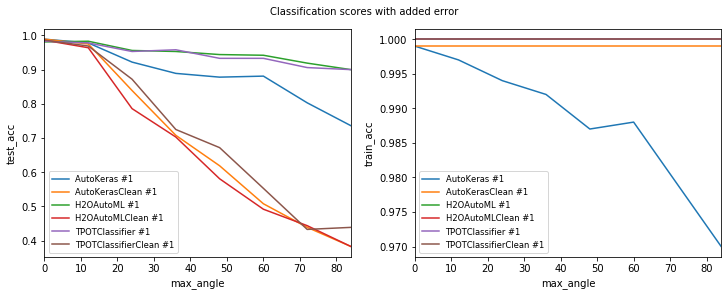

In [10]:
print_results_by_model(
    df, 
    ["train_labels", "test_labels"],
    err_param_name="max_angle",
    pipeline_name="best_pipeline",
)
visualize(df)